## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib as pl
from sklearn.model_selection import train_test_split

## Train CNN

### Preview data

In [8]:
POS_PATH = pl.Path('../pos/')
if not POS_PATH.is_dir():
    raise IOError('path not valid')

NBR_POS_FILES = len(list(POS_PATH.iterdir()))
print(NBR_POS_FILES)

8362


In [9]:
NEG_PATH = pl.Path('../neg/')
if not NEG_PATH.is_dir():
    raise IOError('path not valid')

NBR_NEG_FILES = len(list(NEG_PATH.iterdir()))
print(NBR_NEG_FILES)

10000


In [10]:
first_file = list(POS_PATH.iterdir())[0]
str(first_file)

'../pos/generated_0_9508.jpg'

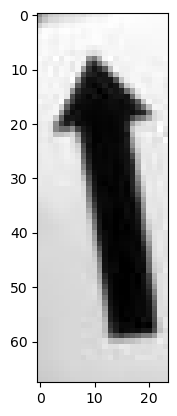

In [11]:
img = cv2.imread(str(first_file))
plt.imshow(img)

In [12]:
img.shape

(68, 24, 3)

### Prepare data

In [13]:
images = np.empty(((NBR_POS_FILES + NBR_NEG_FILES), img.shape[0], img.shape[1], 1))

for idx, filename in enumerate(POS_PATH.iterdir()):
    pos_img = cv2.imread(str(filename), cv2.IMREAD_GRAYSCALE)
    images[idx, :, :, 0]  = pos_img

offset = idx
for idx, filename in enumerate(NEG_PATH.iterdir()):
    neg_img = cv2.imread(str(filename), cv2.IMREAD_GRAYSCALE)
    final_idx = idx + offset
    
    if final_idx >= images.shape[0]:
        break
        
    images[final_idx, :, :, 0] = neg_img

In [14]:
images = images / 255

In [15]:
pos_labels = np.ones((NBR_POS_FILES), dtype=np.intp)

In [16]:
neg_labels = np.zeros((NBR_NEG_FILES), dtype=np.intp)

In [17]:
labels = np.concatenate((pos_labels, neg_labels))

In [18]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=.2, random_state=42)

In [19]:
images_train.shape

(14689, 68, 24, 1)

In [20]:
images_test.shape

(3673, 68, 24, 1)

In [21]:
labels_train.shape

(14689,)

In [22]:
np.save('images_train.npy', images_train)
np.save('images_test.npy', images_test)
np.save('labels_train.npy', labels_train)
np.save('labels_test.npy', labels_test)

In [23]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Prepare model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt

2024-10-18 22:00:05.052085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
images_train = np.load('images_train.npy')
labels_train = np.load('labels_train.npy')
images_test = np.load('images_test.npy')
labels_test = np.load('labels_test.npy')

In [26]:
model = Sequential()

model.add(Conv2D(filters=40, kernel_size=(3, 3), input_shape=(images_train.shape[1], images_train.shape[2], 1), activation='relu', strides=(2, 2), padding='same'))
#model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(2, 2), padding='same'))
#model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 12, 40)        400       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 6, 32)         11552     
                                                                 
 flatten (Flatten)           (None, 3264)              0         
                                                                 
 dense (Dense)               (None, 256)               835840    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 848,049
Trainable params: 848,049
Non-trai

2024-10-18 22:00:07.970328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
epochs = 30
batch_size = 2_000

In [28]:
history = model.fit(images_train, labels_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(images_test, labels_test),
)
model.save('arrow_detection.h5')

Epoch 1/30
8/8 [==============================] - 4s 350ms/step - loss: 0.3683 - accuracy: 0.8691 - val_loss: 0.0435 - val_accuracy: 0.9932
Epoch 2/30
8/8 [==============================] - 2s 296ms/step - loss: 0.0200 - accuracy: 0.9963 - val_loss: 0.0225 - val_accuracy: 0.9954
Epoch 3/30
8/8 [==============================] - 2s 293ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0235 - val_accuracy: 0.9959
Epoch 4/30
8/8 [==============================] - 2s 297ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0255 - val_accuracy: 0.9959
Epoch 5/30
8/8 [==============================] - 2s 271ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0174 - val_accuracy: 0.9970
Epoch 6/30
8/8 [==============================] - 2s 295ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0138 - val_accuracy: 0.9978
Epoch 7/30
8/8 [==============================] - 2s 285ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0111 - val_accuracy: 0.9978
Epoch 8/30
8/8 [====

In [9]:
from keras.models import load_model
model = load_model('arrow_detection.h5')

In [12]:
prediction = model.predict(images_test[0][None])
print(f'prediction:{prediction[0][0]:.2f}')

1/1 [==============================] - 0s 65ms/step
prediction:1.00


In [13]:
print(f'real:{labels_test[0]}')

real:1


In [31]:
from sklearn.metrics import classification_report
predictions = (model.predict(images_test) > 0.5).astype("int32")
print(classification_report(labels_test, predictions))

115/115 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2007
           1       1.00      1.00      1.00      1666

    accuracy                           1.00      3673
   macro avg       1.00      1.00      1.00      3673
weighted avg       1.00      1.00      1.00      3673



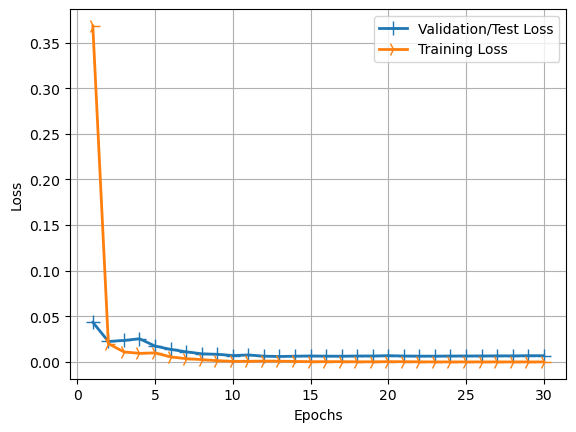

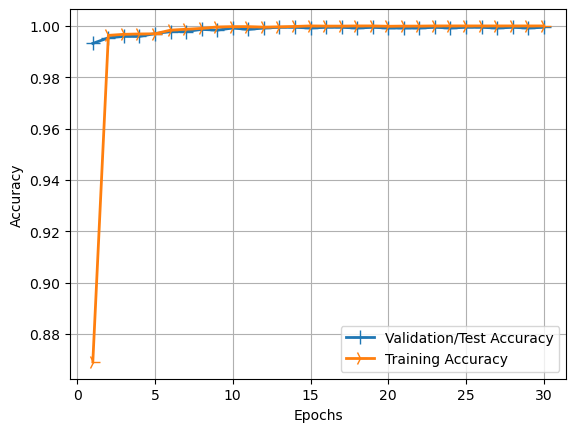

In [32]:
plt_epochs = range(1, (epochs + 1))

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

line1 = plt.plot(plt_epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(plt_epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

line1 = plt.plot(plt_epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(plt_epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Saliency

(10, 68, 24, 1)


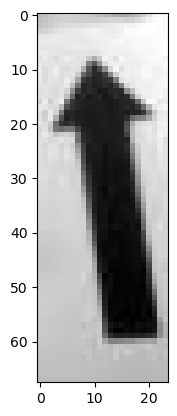

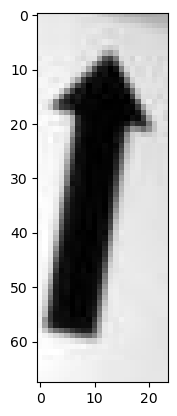

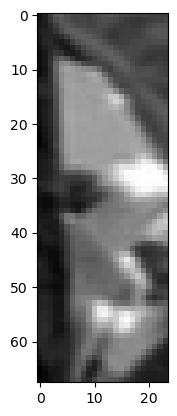

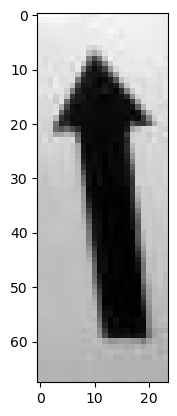

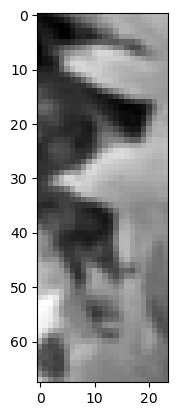

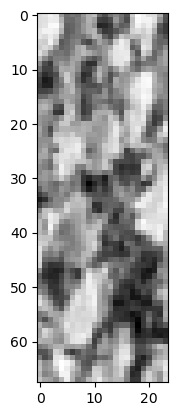

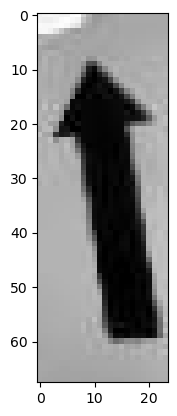

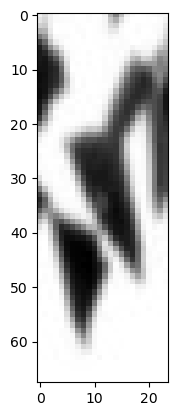

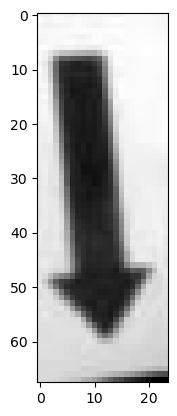

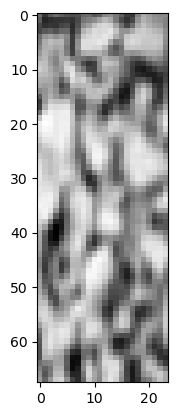

In [33]:
images_test.shape
saliency_part = images_test[:10]
print(saliency_part.shape)
for i in saliency_part:
    plt.imshow(i, cmap='gray')
    plt.show()

In [36]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [37]:
def score_function(output):
    return (output[0][0], output[1][0], output[2][0], output[3][0], output[3][0], output[4][0], output[5][0], output[6][0], output[7][0], output[8][0], output[9][0])

In [38]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

In [39]:
saliency_map = saliency(score_function, saliency_part)
saliency_map.shape

(10, 68, 24)

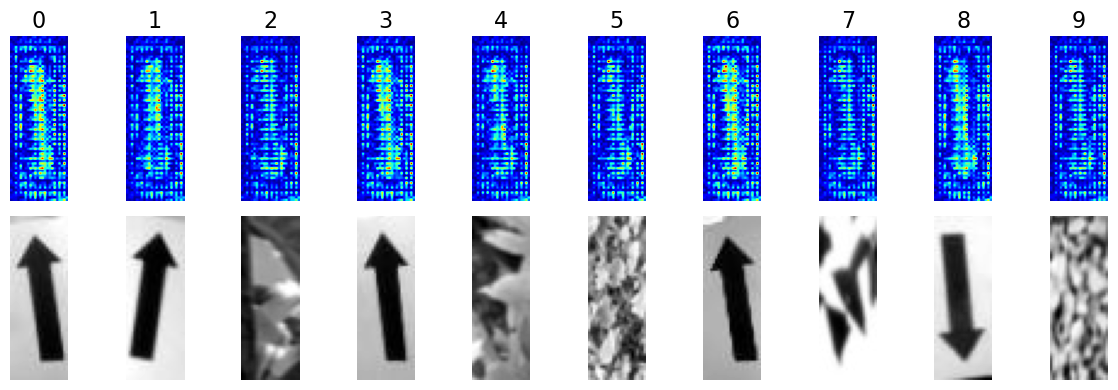

In [40]:
# Render
image_titles = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
f, ax = plt.subplots(nrows=2, ncols=len(image_titles), figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(saliency_map[i], cmap='jet')
    ax[0, i].axis('off')
    ax[1, i].imshow(saliency_part[i], cmap='gray')
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()

### Test single image

In [3]:
img_filename = '../50_cm.jpg'

In [5]:
img_filename = '../multiple.jpg'

model already loaded
1/1 [==============================] - 0s 136ms/step
(2, 1)
[[0.1831998 ]
 [0.19678691]]


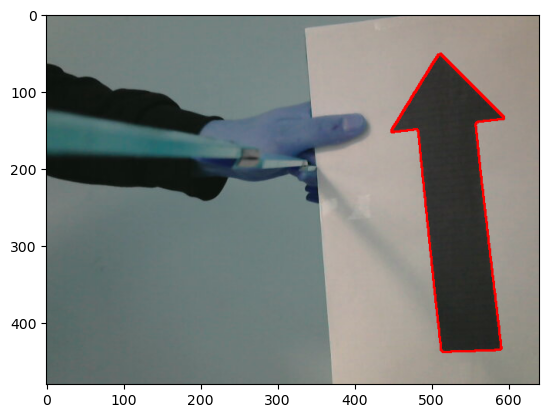

done


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.h5')
    print('loaded model')
    
else:
    print('model already loaded')
    
model.trainable = False

COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

def rotate_and_crop_min_rect(image, min_area_rect):
    factor = 1.3

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    #angle = prepare_rotation(min_area_rect)
    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        angle = -1 * (90 - min_rect[2])
    else:
        angle = min_rect[2]    
        
    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    cropped = cv2.getRectSubPix(image, size, center) 
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)
    
    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated


img = cv2.imread(img_filename)

if img is None:
    raise IOError('file not valid')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.blur(gray_img, (3,3))

sigma = 0.33
# v = np.median(gray_img)
v = np.median(blurred)

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
thresh_img = cv2.Canny(blurred, lower, upper)
cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

filtered_list = []
pos_filtered_to_pos_source = {}
pos_filtered = 0
for pos_source, con in enumerate(cnts):
    min_rect = cv2.minAreaRect(con)
    center, size, angle = min_rect
    area = size[0] * size[1]

    if area < AREA_BORDER:
        continue

    low_value = min(size[0], size[1])
    high_value = max(size[0], size[1])
    width_to_height = low_value / high_value

    if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
        cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
        small_img = cv2.resize(cropped_img, COMPARED_SIZE)
        small_img = small_img / 255
        filtered_list.append(small_img)
        pos_filtered_to_pos_source[pos_filtered] = pos_source
        pos_filtered += 1

filtered_list = np.array(filtered_list)
prediction = model.predict(filtered_list)
print(prediction.shape)
print(prediction)

positive_contours = []
negative_contours = []

for pos, value in enumerate(prediction):
    idx = pos_filtered_to_pos_source[pos]
    if value[0] >= 0.5:
        positive_contours.append(cnts[idx])
    else:
        negative_contours.append(cnts[idx])

positive_contours = np.array(positive_contours, dtype=object)
negative_contours = np.array(negative_contours, dtype=object)
cv2.drawContours(img, positive_contours, -1, (0,0,255), 2)
cv2.drawContours(img, negative_contours, -1, (255,0,0), 2)

plt.imshow(img, cmap='gray')
plt.show()
print('done')


### Tests with camera

In [5]:
cam_nbr = 0

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import threading
from queue import Queue

if not 'model' in dir():
    print('load model...')
    from keras.models import load_model
    model = load_model('arrow_detection.h5')
    print('loaded model')

else:
    print('model already loaded')
    
model.trainable = False

COMPARED_SIZE = (24, 68)
AREA_BORDER = COMPARED_SIZE[0] * COMPARED_SIZE[1]
WIDTH_TO_HEIGHT = COMPARED_SIZE[0] / COMPARED_SIZE[1]
SIZE_FACTOR = 0.3
MIN_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 - SIZE_FACTOR)
MAX_WIDTH_TO_HEIGHT = WIDTH_TO_HEIGHT * (1 + SIZE_FACTOR)

WINDOW_TITLE = 'detect-arrow'

def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]

def rotate_and_crop_min_rect(image, min_area_rect):
    factor = 1.3

    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    width = round(min_area_rect[1][0])
    height = round(min_area_rect[1][1])

    size_of_transformed_image = max(min_area_rect[1])
    min_needed_height = int(np.sqrt(2 * np.power(size_of_transformed_image, 2)))

    width_to_height = min_area_rect[1][0] / min_area_rect[1][1]
    
    if width_to_height >= 1:
        angle = -1 * (90 - min_rect[2])
    else:
        angle = min_rect[2]    
        
    size = (min_needed_height, min_needed_height)

    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    rotated = False
    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
  
    cropped = cv2.getRectSubPix(image, size, center) 
  
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    cropped = cv2.warpAffine(cropped, M, size)
    
    if width_to_height >= 1:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * height), int(factor * width)), (size[0]/2, size[1]/2))
    else:
        cropped_rotated = cv2.getRectSubPix(cropped, (int(factor * width), int(factor * height)), (size[0]/2, size[1]/2))

    return cropped_rotated


# bufferless VideoCapture
class VideoCapture:
    def __init__(self, *args):
        self.image = None
        self.stopped = False
        self.Q = Queue(maxsize=2)
        self.cap = cv2.VideoCapture(*args)
        self.lock = threading.Lock()
        self.event = threading.Event()
        self.t = threading.Thread(target=self._reader)
        self.t.start()

    def _reader(self):
        while not self.event.is_set():
            with self.lock:
                if self.Q.full():
                    _ = self.Q.get()  # remove value for new ones
                    
                ret, image = self.cap.read()
                if not ret:
                    self.cap.release()
                    raise ValueError('could not get image from VideoCapture')
                    
                self.Q.put(image)

    def read(self):
        return True, self.Q.get()

    def isOpened(self):
        return self.cap.isOpened()

    def set(self, *args):
        with self.lock:
            self.cap.set(*args)

    def release(self):
        self.event.set()
        self.t.join()
        self.cap.release()


cap = VideoCapture(cam_nbr)

if not cap.isOpened():
    cap.release()
    print('could not open camera at 2')
    SystemExit(1)


abort = False

while not abort:
    ret, img = cap.read()
    
    blurred = cv2.blur(img, (3,3))
    gray_img = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

    sigma = 0.33
    v = np.median(gray_img)

    #---- apply automatic Canny edge detection using the computed median----
    lower = int(max(0, (1.0 - sigma) * v))    #---- lower threshold
    upper = int(min(255, (1.0 + sigma) * v))  #---- upper threshold
    thresh_img = cv2.Canny(gray_img, lower, upper)
    cnts, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    prechecked_min_rects = []
    for idx, con in enumerate(cnts):
        min_rect = cv2.minAreaRect(con)
        center, size, angle = min_rect
        area = size[0] * size[1]
    
        if area < AREA_BORDER:
            continue
    
        low_value = min(size[0], size[1])
        high_value = max(size[0], size[1])
        width_to_height = low_value / high_value

        # start prediction
        if MIN_WIDTH_TO_HEIGHT < width_to_height < MAX_WIDTH_TO_HEIGHT:
            cropped_img = rotate_and_crop_min_rect(gray_img, min_rect)
            small_img = cv2.resize(cropped_img, COMPARED_SIZE)
            small_img = small_img / 255
            prediction = model.predict(small_img[None], verbose = 0)[0][0]
            prediction = model(small_img[None])[0][0]
           
            box = cv2.boxPoints(min_rect)
            box = np.int0(box)
            
            if prediction > 0.5:
               
                cv2.drawContours(img, [box], 0, (255,0,0), 2)
            else:
                cv2.drawContours(img, [box], 0, (0,0,255), 2)
                    
    cv2.imshow(WINDOW_TITLE, img)
    key = cv2.waitKey(25) & 0xFF

    if key == 27 or key == 113:
        print('aborting')
        abort = True
        break

cap.release()
cv2.destroyAllWindows()
print('done')


model already loaded


[ WARN:0@2272.271] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


aborting
done


## Commentary

The f1-score is not realistic, which is shown in a camera test.  
Further optimization should be done.  